# Experiment 5.2 Gender classification with confounding

In [1]:
import os
import sys
from pathlib import Path
parent_dir = str(Path().resolve().parent)
sys.path.append(parent_dir)
os.chdir(parent_dir)
import data_handler
import configs
import train
import pandas as pd
import matplotlib.pyplot as plt
SEED = 7

### CelebA handcrafted datasets with known confounding

This we coded directly in the notebook to experiment with how to create the datasets

In [5]:
prop = 0.85
n = 1808
train_ds, _, _, img_dir = data_handler.load_original_celebA()

men_with_glasses = train_ds[(train_ds['Male'] == 1) & (train_ds['Eyeglasses'] == 1)].groupby('ID').sample(n=1, random_state=SEED)
men_without_glasses = train_ds[(train_ds['Male'] == 1) & (train_ds['Eyeglasses'] == 0)].groupby('ID').sample(n=1, random_state=SEED)
women_with_glasses = train_ds[(train_ds['Male'] == 0) & (train_ds['Eyeglasses'] == 1)].groupby('ID').sample(n=1, random_state=SEED)
women_without_glasses = train_ds[(train_ds['Male'] == 0) & (train_ds['Eyeglasses'] == 0)].groupby('ID').sample(n=1, random_state=SEED)

mg = men_with_glasses.sample(n)
mwg = men_without_glasses[men_without_glasses['ID'].isin(mg['ID'])].sample(int((1-prop)*n))
wwg = women_without_glasses.sample(n)
wg =   women_with_glasses[women_with_glasses['ID'].isin(wwg['ID'])].sample(int((1-prop)*n))
train_ds = pd.concat([mg, mwg, wwg, wg])

config = configs.celebA_experiment()
# ignore first two arguments
_, test1_ds, test2_ds, img_dir = data_handler.load_datasets_celebA_counfound(0.95, 10_000, config.test_size)

len(men_with_glasses), len(men_without_glasses), len(women_with_glasses), len(women_without_glasses)

print("Train set size: ", len(train_ds))
id_counts = train_ds['ID'].value_counts()
print("Distinct IDs that occur more than once: ", id_counts[id_counts > 1].count())
print("Mean occurrences of IDs: ", id_counts.mean())
print("Max occurrences of IDs: ", id_counts.max())

cross_tab = pd.crosstab(index=train_ds['Male'], columns=train_ds['Eyeglasses'])

cross_tab_percentage = cross_tab.div(cross_tab.sum().sum()) * 100

print("\n\nPercentage of images for each combination of gender and eyeglasses status:")
print(cross_tab_percentage)

grouped = train_ds.groupby(['ID', 'Eyeglasses']).size().unstack(fill_value=0)
ids_with_and_without_glasses = grouped[(grouped[0] > 0) & (grouped[1] > 0)]
distinct_ids_count = len(ids_with_and_without_glasses)
print("\n\nNumber of distinct IDs with at least one instance of eyeglasses being worn and not worn:", distinct_ids_count)
print("These IDs encompass a total of", ids_with_and_without_glasses.sum().sum(), "images")
print("Mean number of images with glasses per ID:", ids_with_and_without_glasses[1].mean())
print("Mean number of images without glasses per ID:", ids_with_and_without_glasses[0].mean())

train_ds = data_handler.conv_celebA_to_jax(train_ds, img_dir)
test1_ds = data_handler.conv_celebA_to_jax(test1_ds, img_dir)
test2_ds = data_handler.conv_celebA_to_jax(test2_ds, img_dir)

Train set size:  4678
Distinct IDs that occur more than once:  651
Mean occurrences of IDs:  1.168039950062422
Max occurrences of IDs:  3


Percentage of images for each combination of gender and eyeglasses status:
Eyeglasses         0         1
Male                          
0           43.48012   6.51988
1            6.51988  43.48012


Number of distinct IDs with at least one instance of eyeglasses being worn and not worn: 651
These IDs encompass a total of 1324 images
Mean number of images with glasses per ID: 1.0245775729646698
Mean number of images without glasses per ID: 1.0092165898617511


In [7]:
config = configs.celebA_experiment()
config.lambda_core = 0.0

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 3.0887, train_accuracy: 52.71, test1_accuracy: 57.67, test2_accuracy: 48.57, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 4.11
INFO:absl:epoch: 2, train_loss: 2.9720, train_accuracy: 59.14, test1_accuracy: 70.03, test2_accuracy: 48.93, core_penalty: 0.0005, val_loss: N/A, ids_more_than_once: 3.44
INFO:absl:epoch: 3, train_loss: 2.7427, train_accuracy: 67.80, test1_accuracy: 69.15, test2_accuracy: 48.75, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 3.67
INFO:absl:epoch: 4, train_loss: 2.4293, train_accuracy: 71.12, test1_accuracy: 73.51, test2_accuracy: 46.61, core_penalty: 0.1151, val_loss: N/A, ids_more_than_once: 4.78
INFO:absl:epoch: 5, train_loss: 2.1249, train_accuracy: 75.20, test1_accuracy: 78.20, test2_accuracy: 47.77, core_penalty: 0.1748, val_loss: N/A, ids_more_than_once: 4.56
INFO:absl:epoch: 6, train_loss: 1.8328, train_accuracy: 79.82, test1_accuracy: 84.54, test2_accuracy: 49.55, core_penalty: 0.1442, val_loss: N/A,

In [8]:
config = configs.celebA_experiment()
config.lambda_core = 10.0

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 3.0937, train_accuracy: 52.73, test1_accuracy: 62.81, test2_accuracy: 47.32, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 4.11
INFO:absl:epoch: 2, train_loss: 2.9939, train_accuracy: 57.70, test1_accuracy: 67.83, test2_accuracy: 50.09, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 3.44
INFO:absl:epoch: 3, train_loss: 2.8139, train_accuracy: 66.82, test1_accuracy: 55.40, test2_accuracy: 49.91, core_penalty: 0.0009, val_loss: N/A, ids_more_than_once: 3.67
INFO:absl:epoch: 4, train_loss: 2.6003, train_accuracy: 68.27, test1_accuracy: 74.72, test2_accuracy: 55.54, core_penalty: 0.0028, val_loss: N/A, ids_more_than_once: 4.78
INFO:absl:epoch: 5, train_loss: 2.3570, train_accuracy: 65.69, test1_accuracy: 74.74, test2_accuracy: 53.21, core_penalty: 0.0005, val_loss: N/A, ids_more_than_once: 4.56
INFO:absl:epoch: 6, train_loss: 2.0965, train_accuracy: 67.14, test1_accuracy: 81.30, test2_accuracy: 52.32, core_penalty: 0.0006, val_loss: N/A,

In [9]:
config = configs.celebA_experiment()
config.lambda_core = 10.0
config.no_cfl_frac = 0.1
config.cfl_anneal = True

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 3.0887, train_accuracy: 52.71, test1_accuracy: 57.67, test2_accuracy: 48.57, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 4.11
INFO:absl:epoch: 2, train_loss: 2.9720, train_accuracy: 59.14, test1_accuracy: 70.03, test2_accuracy: 48.93, core_penalty: 0.0005, val_loss: N/A, ids_more_than_once: 3.44
INFO:absl:epoch: 3, train_loss: 2.7427, train_accuracy: 67.80, test1_accuracy: 69.15, test2_accuracy: 48.75, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 3.67
INFO:absl:epoch: 4, train_loss: 2.4293, train_accuracy: 71.12, test1_accuracy: 73.51, test2_accuracy: 46.61, core_penalty: 0.1151, val_loss: N/A, ids_more_than_once: 4.78
INFO:absl:epoch: 5, train_loss: 2.1249, train_accuracy: 75.20, test1_accuracy: 78.20, test2_accuracy: 47.77, core_penalty: 0.1748, val_loss: N/A, ids_more_than_once: 4.56
INFO:absl:epoch: 6, train_loss: 1.8328, train_accuracy: 79.82, test1_accuracy: 84.54, test2_accuracy: 49.55, core_penalty: 0.1442, val_loss: N/A,

In [16]:
prop = 0.95
n = 1808
train_ds, _, _, img_dir = data_handler.load_original_celebA()

men_with_glasses = train_ds[(train_ds['Male'] == 1) & (train_ds['Eyeglasses'] == 1)].groupby('ID').sample(n=1, random_state=SEED)
men_without_glasses = train_ds[(train_ds['Male'] == 1) & (train_ds['Eyeglasses'] == 0)].groupby('ID').sample(n=1, random_state=SEED)
women_with_glasses = train_ds[(train_ds['Male'] == 0) & (train_ds['Eyeglasses'] == 1)].groupby('ID').sample(n=1, random_state=SEED)
women_without_glasses = train_ds[(train_ds['Male'] == 0) & (train_ds['Eyeglasses'] == 0)].groupby('ID').sample(n=1, random_state=SEED)

mg = men_with_glasses.sample(n)
mwg = men_without_glasses[men_without_glasses['ID'].isin(mg['ID'])].sample(int((1-prop)*n))
wwg = women_without_glasses.sample(n)
wg =   women_with_glasses[women_with_glasses['ID'].isin(wwg['ID'])].sample(int((1-prop)*n))
train_ds = pd.concat([mg, mwg, wwg, wg])

config = configs.celebA_experiment()
# ignore first two arguments
_, test1_ds, test2_ds, img_dir = data_handler.load_datasets_celebA_counfound(0.95, 10_000, config.test_size)

len(men_with_glasses), len(men_without_glasses), len(women_with_glasses), len(women_without_glasses)

print("Train set size: ", len(train_ds))
id_counts = train_ds['ID'].value_counts()
print("Distinct IDs that occur more than once: ", id_counts[id_counts > 1].count())
print("Mean occurrences of IDs: ", id_counts.mean())
print("Max occurrences of IDs: ", id_counts.max())

cross_tab = pd.crosstab(index=train_ds['Male'], columns=train_ds['Eyeglasses'])

cross_tab_percentage = cross_tab.div(cross_tab.sum().sum()) * 100

print("\n\nPercentage of images for each combination of gender and eyeglasses status:")
print(cross_tab_percentage)

grouped = train_ds.groupby(['ID', 'Eyeglasses']).size().unstack(fill_value=0)
ids_with_and_without_glasses = grouped[(grouped[0] > 0) & (grouped[1] > 0)]
distinct_ids_count = len(ids_with_and_without_glasses)
print("\n\nNumber of distinct IDs with at least one instance of eyeglasses being worn and not worn:", distinct_ids_count)
print("These IDs encompass a total of", ids_with_and_without_glasses.sum().sum(), "images")
print("Mean number of images with glasses per ID:", ids_with_and_without_glasses[1].mean())
print("Mean number of images without glasses per ID:", ids_with_and_without_glasses[0].mean())

train_ds = data_handler.conv_celebA_to_jax(train_ds, img_dir)
test1_ds = data_handler.conv_celebA_to_jax(test1_ds, img_dir)
test2_ds = data_handler.conv_celebA_to_jax(test2_ds, img_dir)

Train set size:  3796
Distinct IDs that occur more than once:  234
Mean occurrences of IDs:  1.067191453472027
Max occurrences of IDs:  3


Percentage of images for each combination of gender and eyeglasses status:
Eyeglasses          0          1
Male                            
0           47.629083   2.370917
1            2.370917  47.629083


Number of distinct IDs with at least one instance of eyeglasses being worn and not worn: 234
These IDs encompass a total of 473 images
Mean number of images with glasses per ID: 1.017094017094017
Mean number of images without glasses per ID: 1.0042735042735043


In [12]:
config = configs.celebA_experiment()
config.lambda_core = 0.0

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 3.0967, train_accuracy: 51.31, test1_accuracy: 60.75, test2_accuracy: 48.30, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 2.43
INFO:absl:epoch: 2, train_loss: 3.0232, train_accuracy: 65.32, test1_accuracy: 64.49, test2_accuracy: 47.23, core_penalty: 0.0005, val_loss: N/A, ids_more_than_once: 2.71
INFO:absl:epoch: 3, train_loss: 2.8759, train_accuracy: 67.86, test1_accuracy: 67.59, test2_accuracy: 46.79, core_penalty: 0.0023, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 4, train_loss: 2.6636, train_accuracy: 68.64, test1_accuracy: 70.64, test2_accuracy: 46.52, core_penalty: 0.0300, val_loss: N/A, ids_more_than_once: 3.43
INFO:absl:epoch: 5, train_loss: 2.4119, train_accuracy: 72.74, test1_accuracy: 74.22, test2_accuracy: 42.68, core_penalty: 0.0863, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 6, train_loss: 2.1762, train_accuracy: 76.12, test1_accuracy: 77.58, test2_accuracy: 38.39, core_penalty: 0.0682, val_loss: N/A,

In [13]:
config = configs.celebA_experiment()
config.lambda_core = 2.0

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 3.0973, train_accuracy: 51.31, test1_accuracy: 60.27, test2_accuracy: 47.68, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 2.43
INFO:absl:epoch: 2, train_loss: 3.0249, train_accuracy: 65.01, test1_accuracy: 62.50, test2_accuracy: 46.96, core_penalty: 0.0004, val_loss: N/A, ids_more_than_once: 2.71
INFO:absl:epoch: 3, train_loss: 2.8855, train_accuracy: 67.66, test1_accuracy: 69.08, test2_accuracy: 47.77, core_penalty: 0.0018, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 4, train_loss: 2.7065, train_accuracy: 69.53, test1_accuracy: 73.53, test2_accuracy: 47.68, core_penalty: 0.0094, val_loss: N/A, ids_more_than_once: 3.43
INFO:absl:epoch: 5, train_loss: 2.5106, train_accuracy: 73.10, test1_accuracy: 77.27, test2_accuracy: 45.98, core_penalty: 0.0171, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 6, train_loss: 2.2983, train_accuracy: 75.56, test1_accuracy: 77.41, test2_accuracy: 49.02, core_penalty: 0.0079, val_loss: N/A,

In [17]:
config = configs.celebA_experiment()
config.lambda_core = 10.0

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 3.1018, train_accuracy: 50.45, test1_accuracy: 56.37, test2_accuracy: 49.20, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 3.14
INFO:absl:epoch: 2, train_loss: 3.0369, train_accuracy: 64.43, test1_accuracy: 63.57, test2_accuracy: 47.32, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 1.71
INFO:absl:epoch: 3, train_loss: 2.9192, train_accuracy: 67.27, test1_accuracy: 69.65, test2_accuracy: 48.84, core_penalty: 0.0004, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 4, train_loss: 2.7670, train_accuracy: 71.90, test1_accuracy: 70.60, test2_accuracy: 49.11, core_penalty: 0.0017, val_loss: N/A, ids_more_than_once: 2.57
INFO:absl:epoch: 5, train_loss: 2.5687, train_accuracy: 73.02, test1_accuracy: 76.99, test2_accuracy: 51.34, core_penalty: 0.0005, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 6, train_loss: 2.4318, train_accuracy: 67.83, test1_accuracy: 52.65, test2_accuracy: 49.20, core_penalty: 0.0063, val_loss: N/A,

In [18]:
config = configs.celebA_experiment()
config.lambda_core = 0.1

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 3.0970, train_accuracy: 50.98, test1_accuracy: 59.97, test2_accuracy: 48.57, core_penalty: 0.0004, val_loss: N/A, ids_more_than_once: 3.14
INFO:absl:epoch: 2, train_loss: 3.0239, train_accuracy: 65.12, test1_accuracy: 63.61, test2_accuracy: 46.88, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 1.71
INFO:absl:epoch: 3, train_loss: 2.8780, train_accuracy: 67.38, test1_accuracy: 67.50, test2_accuracy: 46.52, core_penalty: 0.0014, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 4, train_loss: 2.6684, train_accuracy: 69.34, test1_accuracy: 70.88, test2_accuracy: 46.61, core_penalty: 0.0169, val_loss: N/A, ids_more_than_once: 2.57
INFO:absl:epoch: 5, train_loss: 2.4194, train_accuracy: 73.30, test1_accuracy: 77.23, test2_accuracy: 43.57, core_penalty: 0.0282, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 6, train_loss: 2.1858, train_accuracy: 77.90, test1_accuracy: 81.42, test2_accuracy: 39.91, core_penalty: 0.1942, val_loss: N/A,

In [14]:
config = configs.celebA_experiment()
config.lambda_core = 100.0
config.no_cfl_frac = 0.2
config.cfl_anneal = True

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 3.0967, train_accuracy: 51.31, test1_accuracy: 60.75, test2_accuracy: 48.30, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 2.43
INFO:absl:epoch: 2, train_loss: 3.0232, train_accuracy: 65.32, test1_accuracy: 64.49, test2_accuracy: 47.23, core_penalty: 0.0005, val_loss: N/A, ids_more_than_once: 2.71
INFO:absl:epoch: 3, train_loss: 2.8759, train_accuracy: 67.86, test1_accuracy: 67.59, test2_accuracy: 46.79, core_penalty: 0.0023, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 4, train_loss: 2.6636, train_accuracy: 68.64, test1_accuracy: 70.64, test2_accuracy: 46.52, core_penalty: 0.0300, val_loss: N/A, ids_more_than_once: 3.43
INFO:absl:epoch: 5, train_loss: 2.4119, train_accuracy: 72.74, test1_accuracy: 74.22, test2_accuracy: 42.68, core_penalty: 0.0863, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 6, train_loss: 2.1762, train_accuracy: 76.12, test1_accuracy: 77.58, test2_accuracy: 38.39, core_penalty: 0.0682, val_loss: N/A,

### CelebA handcrafted datasets with unknown confounding

In [23]:
config = configs.celebA_experiment()
train_ds, test1_ds, test2_ds, img_dir = data_handler.load_datasets_celebA_counfound(0.95, config.train_size, config.test_size)

In [24]:
print("Train set size: ", len(train_ds))
id_counts = train_ds['ID'].value_counts()
print("Distinct IDs that occur more than once: ", id_counts[id_counts > 1].count())
print("Mean occurrences of IDs: ", id_counts.mean())
print("Max occurrences of IDs: ", id_counts.max())

cross_tab = pd.crosstab(index=train_ds['Male'], columns=train_ds['Eyeglasses'])

cross_tab_percentage = cross_tab.div(cross_tab.sum().sum()) * 100

print("\n\nPercentage of images for each combination of gender and eyeglasses status:")
print(cross_tab_percentage)

grouped = train_ds.groupby(['ID', 'Eyeglasses']).size().unstack(fill_value=0)
ids_with_and_without_glasses = grouped[(grouped[0] > 0) & (grouped[1] > 0)]
distinct_ids_count = len(ids_with_and_without_glasses)
print("\n\nNumber of distinct IDs with at least one instance of eyeglasses being worn and not worn:", distinct_ids_count)
print("These IDs encompass a total of", ids_with_and_without_glasses.sum().sum(), "images")
print("Mean number of images with glasses per ID:", ids_with_and_without_glasses[1].mean())
print("Mean number of images without glasses per ID:", ids_with_and_without_glasses[0].mean())

Train set size:  20000
Distinct IDs that occur more than once:  4235
Mean occurrences of IDs:  3.2175032175032174
Max occurrences of IDs:  29


Percentage of images for each combination of gender and eyeglasses status:
Eyeglasses     0     1
Male                  
0           40.0  10.0
1           10.0  40.0


Number of distinct IDs with at least one instance of eyeglasses being worn and not worn: 1385
These IDs encompass a total of 5951 images
Mean number of images with glasses per ID: 2.395667870036101
Mean number of images without glasses per ID: 1.9010830324909747


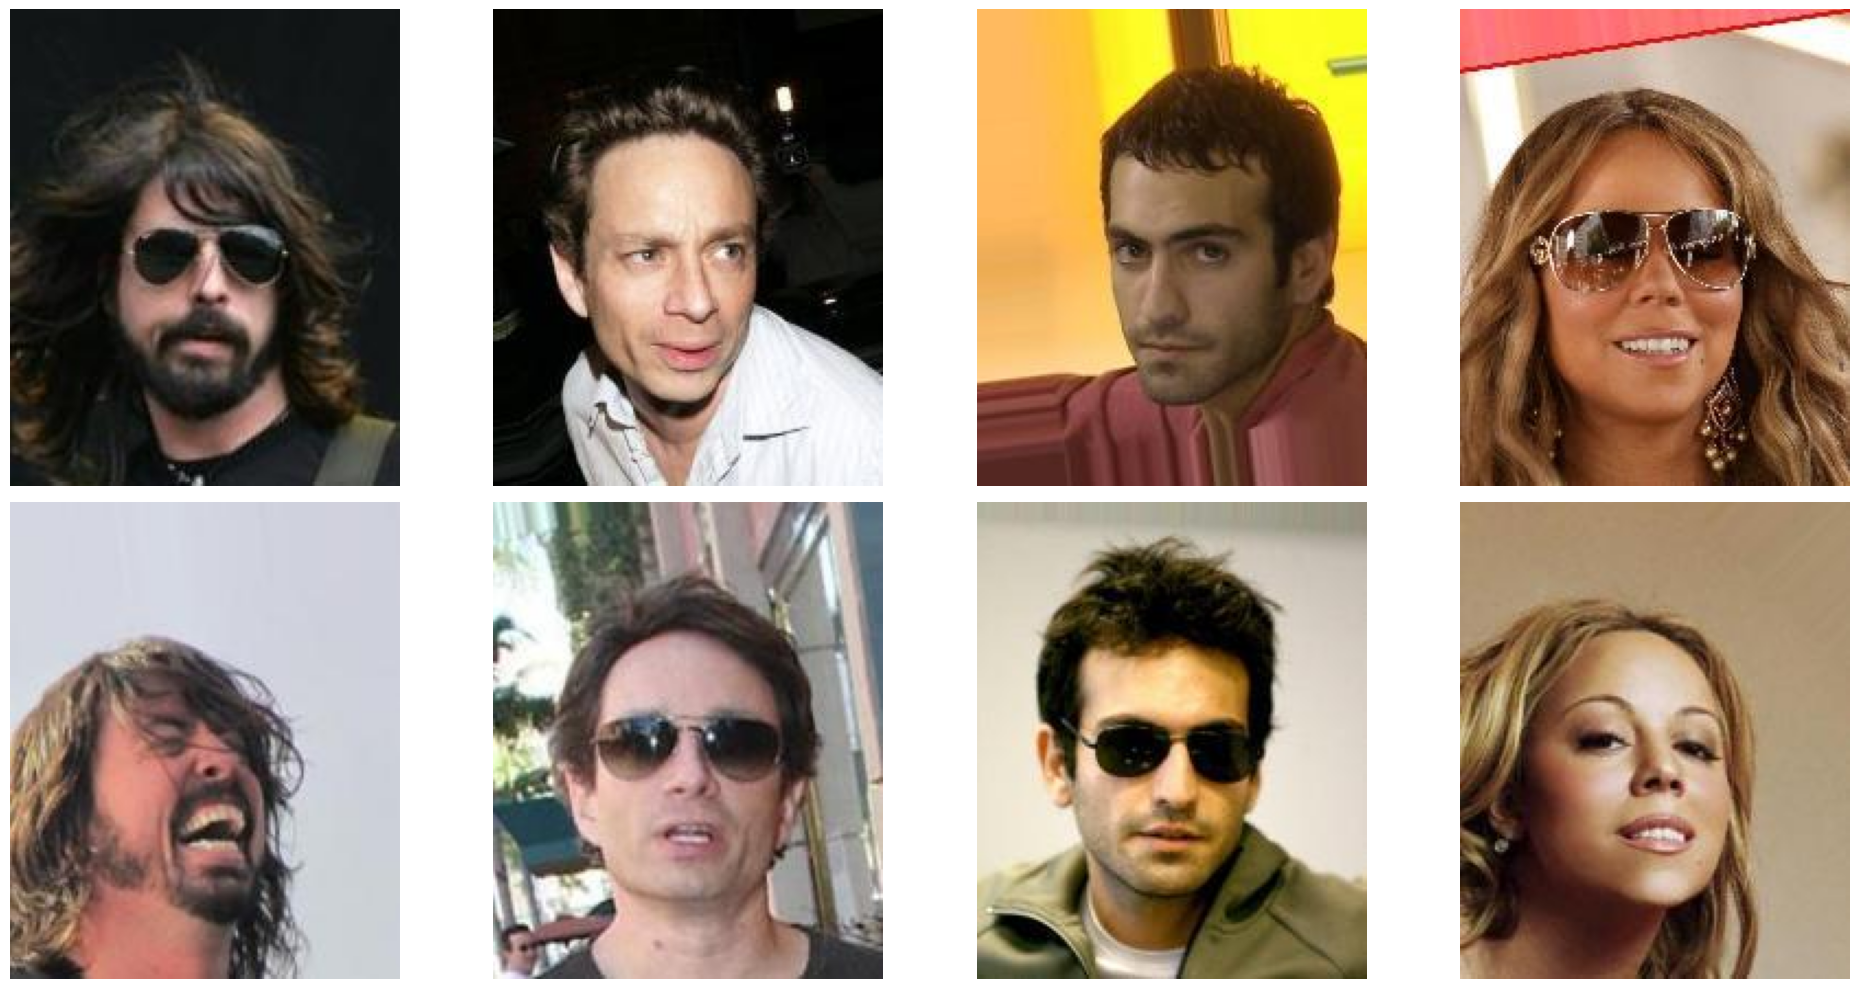

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the figsize as needed

ID = ids_with_and_without_glasses[(ids_with_and_without_glasses[0] == 1) & (ids_with_and_without_glasses[1] == 1)].sample(4).index

for col in range(4):
    images = train_ds[train_ds['ID'] == ID[col]]['image_id'].values
    row = 0
    for img in images:
        img_path = f'{img_dir}/{img}'
        image = plt.imread(img_path)

        # Display images in vertical order for the same ID
        axs[row][col].imshow(image)  
        axs[row][col].axis('off') 
        row += 1

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

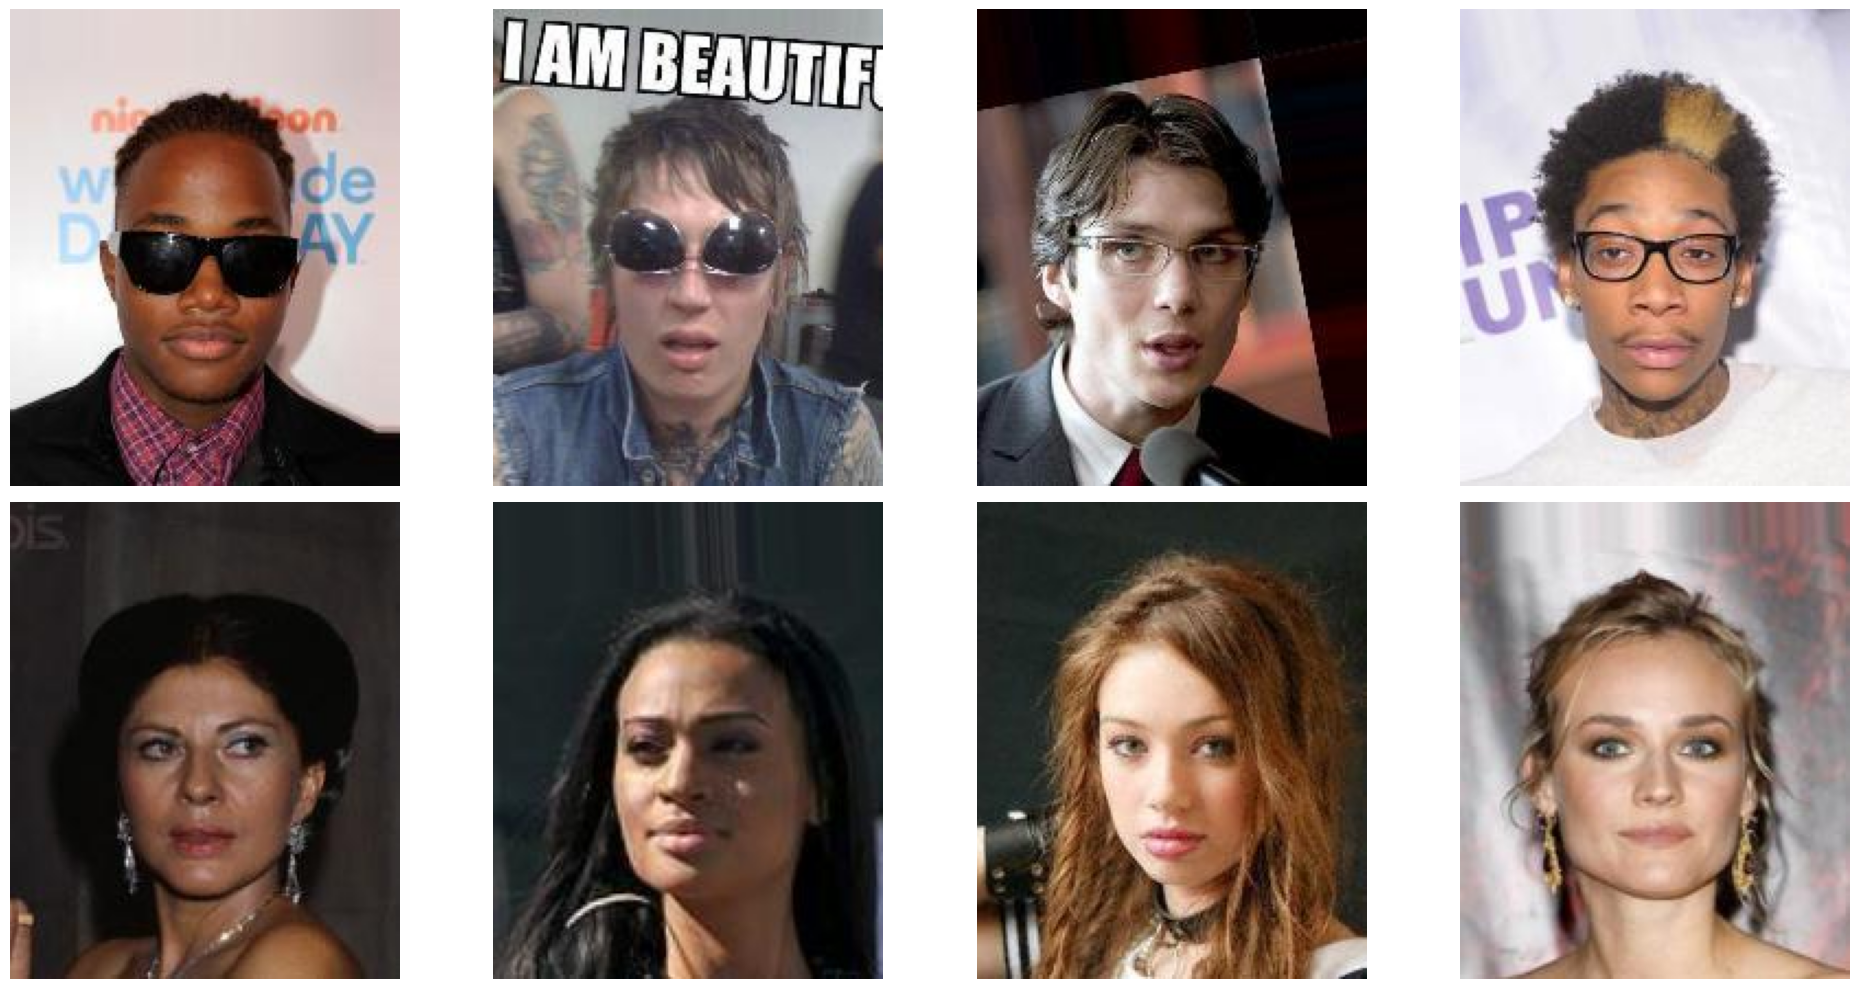

In [ ]:
# Test set 1
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the figsize as needed

for col in range(4):
    # choose two random indices of test1_ds
    man = test1_ds[test1_ds['Male']==1].sample(1)['image_id'].values
    woman = test1_ds[test1_ds['Male']==0].sample(1)['image_id'].values
    row = 0
    for img in [man[0], woman[0]]:
        img_path = f'{img_dir}/{img}'
        image = plt.imread(img_path)

        # Display images in vertical order for the same ID
        axs[row][col].imshow(image)  
        axs[row][col].axis('off') 
        row += 1

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

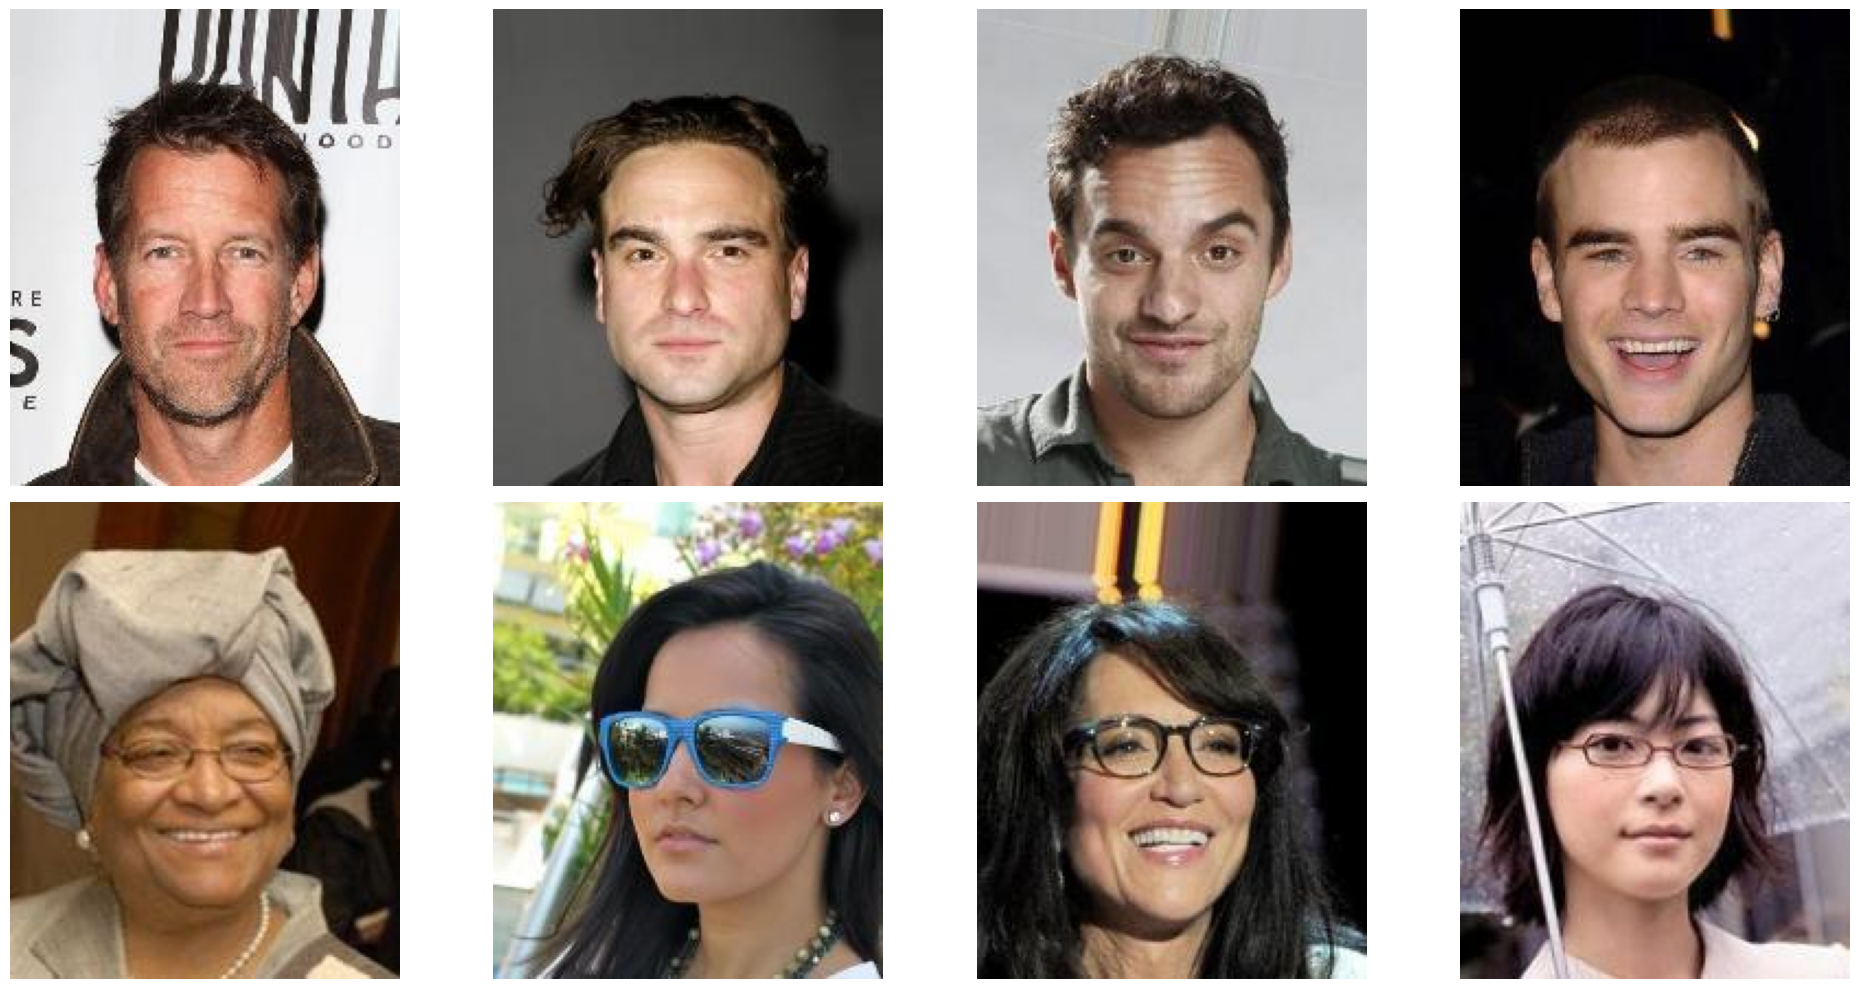

In [ ]:
# Test set 2
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the figsize as needed

for col in range(4):
    # choose two random indices of test1_ds
    man = test2_ds[test2_ds['Male']==1].sample(1)['image_id'].values
    woman = test2_ds[test2_ds['Male']==0].sample(1)['image_id'].values
    row = 0
    for img in [man[0], woman[0]]:
        img_path = f'{img_dir}/{img}'
        image = plt.imread(img_path)

        # Display images in vertical order for the same ID
        axs[row][col].imshow(image)  
        axs[row][col].axis('off') 
        row += 1

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [17]:
train_ds = data_handler.conv_celebA_to_jax(train_ds, img_dir)
test1_ds = data_handler.conv_celebA_to_jax(test1_ds, img_dir)
test2_ds = data_handler.conv_celebA_to_jax(test2_ds, img_dir)

In [21]:
# 0.75
config = configs.celebA_experiment()
config.lambda_core = 10.0

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * (config.num_epochs // 10)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-3
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.9110, train_accuracy: 62.64, test1_accuracy: 84.64, test2_accuracy: 66.07, core_penalty: 0.0008, val_loss: N/A, ids_more_than_once: 17.62
INFO:absl:epoch: 2, train_loss: 0.8358, train_accuracy: 80.23, test1_accuracy: 89.84, test2_accuracy: 63.48, core_penalty: 0.0031, val_loss: N/A, ids_more_than_once: 18.06
INFO:absl:epoch: 3, train_loss: 0.7841, train_accuracy: 82.43, test1_accuracy: 93.82, test2_accuracy: 70.80, core_penalty: 0.0044, val_loss: N/A, ids_more_than_once: 17.20
INFO:absl:epoch: 4, train_loss: 0.7518, train_accuracy: 85.44, test1_accuracy: 91.29, test2_accuracy: 65.62, core_penalty: 0.0058, val_loss: N/A, ids_more_than_once: 16.67
INFO:absl:epoch: 5, train_loss: 0.7274, train_accuracy: 86.34, test1_accuracy: 93.28, test2_accuracy: 73.48, core_penalty: 0.0059, val_loss: N/A, ids_more_than_once: 17.98
INFO:absl:epoch: 6, train_loss: 0.7026, train_accuracy: 86.48, test1_accuracy: 93.99, test2_accuracy: 75.45, core_penalty: 0.0063, val_loss:

KeyboardInterrupt: 

In [19]:
# 0.75
config = configs.celebA_experiment()
config.lambda_core = 0.0

config.batch_size = 256
config.num_epochs = 50

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * (config.num_epochs // 10)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-3
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.8729, train_accuracy: 62.11, test1_accuracy: 78.81, test2_accuracy: 61.43, core_penalty: 0.0138, val_loss: N/A, ids_more_than_once: 17.62
INFO:absl:epoch: 2, train_loss: 0.6189, train_accuracy: 81.30, test1_accuracy: 88.00, test2_accuracy: 74.64, core_penalty: 0.1706, val_loss: N/A, ids_more_than_once: 18.06
INFO:absl:epoch: 3, train_loss: 0.4696, train_accuracy: 87.77, test1_accuracy: 94.84, test2_accuracy: 78.57, core_penalty: 0.3067, val_loss: N/A, ids_more_than_once: 17.20
INFO:absl:epoch: 4, train_loss: 0.4021, train_accuracy: 90.12, test1_accuracy: 94.84, test2_accuracy: 81.16, core_penalty: 0.3514, val_loss: N/A, ids_more_than_once: 16.67
INFO:absl:epoch: 5, train_loss: 0.3473, train_accuracy: 92.02, test1_accuracy: 95.50, test2_accuracy: 85.27, core_penalty: 0.4258, val_loss: N/A, ids_more_than_once: 17.98
INFO:absl:epoch: 6, train_loss: 0.3131, train_accuracy: 93.03, test1_accuracy: 95.90, test2_accuracy: 84.73, core_penalty: 0.5358, val_loss:

KeyboardInterrupt: 

In [33]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 0.0

config.batch_size = 128
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * (config.num_epochs // 10)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.9
config.learning_rate = 1e-2

config.lambda_l2 = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.3022, train_accuracy: 81.00, test1_accuracy: 93.61, test2_accuracy: 50.89, core_penalty: 0.1549, val_loss: N/A, ids_more_than_once: 5.17
INFO:absl:epoch: 2, train_loss: 0.7253, train_accuracy: 84.46, test1_accuracy: 87.50, test2_accuracy: 42.95, core_penalty: 0.2371, val_loss: N/A, ids_more_than_once: 5.80
INFO:absl:epoch: 3, train_loss: 0.6363, train_accuracy: 89.64, test1_accuracy: 94.46, test2_accuracy: 51.43, core_penalty: 0.2523, val_loss: N/A, ids_more_than_once: 5.48
INFO:absl:epoch: 4, train_loss: 1.0175, train_accuracy: 72.73, test1_accuracy: 72.96, test2_accuracy: 60.71, core_penalty: 0.0900, val_loss: N/A, ids_more_than_once: 5.46
INFO:absl:epoch: 5, train_loss: 0.7903, train_accuracy: 73.93, test1_accuracy: 76.54, test2_accuracy: 63.39, core_penalty: 0.0947, val_loss: N/A, ids_more_than_once: 5.30
INFO:absl:epoch: 6, train_loss: 0.6116, train_accuracy: 79.57, test1_accuracy: 86.93, test2_accuracy: 63.66, core_penalty: 0.1364, val_loss: N/A,

In [4]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 10.0

config.batch_size = 128
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * (config.num_epochs // 10)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.9
config.learning_rate = 1e-2

config.lambda_l2 = 1e-2

config.no_cfl_frac = 0.3 # 9 epochs
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.3022, train_accuracy: 81.00, test1_accuracy: 93.61, test2_accuracy: 50.89, core_penalty: 0.1549, val_loss: N/A, ids_more_than_once: 5.17
INFO:absl:epoch: 2, train_loss: 0.7253, train_accuracy: 84.46, test1_accuracy: 87.50, test2_accuracy: 42.95, core_penalty: 0.2371, val_loss: N/A, ids_more_than_once: 5.80
INFO:absl:epoch: 3, train_loss: 0.6363, train_accuracy: 89.64, test1_accuracy: 94.46, test2_accuracy: 51.43, core_penalty: 0.2523, val_loss: N/A, ids_more_than_once: 5.48
INFO:absl:epoch: 4, train_loss: 1.0175, train_accuracy: 72.73, test1_accuracy: 72.96, test2_accuracy: 60.71, core_penalty: 0.0900, val_loss: N/A, ids_more_than_once: 5.46
INFO:absl:epoch: 5, train_loss: 0.7903, train_accuracy: 73.93, test1_accuracy: 76.54, test2_accuracy: 63.39, core_penalty: 0.0947, val_loss: N/A, ids_more_than_once: 5.30
INFO:absl:epoch: 6, train_loss: 0.6116, train_accuracy: 79.57, test1_accuracy: 86.93, test2_accuracy: 63.66, core_penalty: 0.1364, val_loss: N/A,

KeyboardInterrupt: 

In [5]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 10.0

config.batch_size = 128
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * (config.num_epochs // 10)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.9
config.learning_rate = 1e-2

config.lambda_l2 = 1e-2

config.no_cfl_frac = 0.1 # 9 epochs
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.3022, train_accuracy: 81.00, test1_accuracy: 93.61, test2_accuracy: 50.89, core_penalty: 0.1549, val_loss: N/A, ids_more_than_once: 5.17
INFO:absl:epoch: 2, train_loss: 0.7253, train_accuracy: 84.46, test1_accuracy: 87.50, test2_accuracy: 42.95, core_penalty: 0.2371, val_loss: N/A, ids_more_than_once: 5.80
INFO:absl:epoch: 3, train_loss: 0.6363, train_accuracy: 89.64, test1_accuracy: 94.46, test2_accuracy: 51.43, core_penalty: 0.2523, val_loss: N/A, ids_more_than_once: 5.48
INFO:absl:epoch: 4, train_loss: 1.3122, train_accuracy: 51.18, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0040, val_loss: N/A, ids_more_than_once: 5.46
INFO:absl:epoch: 5, train_loss: 0.8855, train_accuracy: 50.19, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0000, val_loss: N/A, ids_more_than_once: 5.30
INFO:absl:epoch: 6, train_loss: 0.7821, train_accuracy: 50.02, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0000, val_loss: N/A,

KeyboardInterrupt: 

In [6]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 0.1

config.batch_size = 128
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * (config.num_epochs // 10)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.9
config.learning_rate = 1e-2

config.lambda_l2 = 1e-2

config.no_cfl_frac = 0.1 # 9 epochs
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.3022, train_accuracy: 81.00, test1_accuracy: 93.61, test2_accuracy: 50.89, core_penalty: 0.1549, val_loss: N/A, ids_more_than_once: 5.17
INFO:absl:epoch: 2, train_loss: 0.7253, train_accuracy: 84.46, test1_accuracy: 87.50, test2_accuracy: 42.95, core_penalty: 0.2371, val_loss: N/A, ids_more_than_once: 5.80
INFO:absl:epoch: 3, train_loss: 0.6363, train_accuracy: 89.64, test1_accuracy: 94.46, test2_accuracy: 51.43, core_penalty: 0.2523, val_loss: N/A, ids_more_than_once: 5.48
INFO:absl:epoch: 4, train_loss: 0.4500, train_accuracy: 90.74, test1_accuracy: 94.65, test2_accuracy: 48.48, core_penalty: 0.1360, val_loss: N/A, ids_more_than_once: 5.46
INFO:absl:epoch: 5, train_loss: 0.3832, train_accuracy: 92.42, test1_accuracy: 95.60, test2_accuracy: 53.39, core_penalty: 0.1885, val_loss: N/A, ids_more_than_once: 5.30
INFO:absl:epoch: 6, train_loss: 0.5067, train_accuracy: 88.74, test1_accuracy: 90.13, test2_accuracy: 48.66, core_penalty: 0.1569, val_loss: N/A,

KeyboardInterrupt: 

In [7]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 10.0

config.batch_size = 128
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * (config.num_epochs // 10)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.9
config.learning_rate = 1e-2

config.lambda_l2 = 1e-2

config.no_cfl_frac = 0.1 # 9 epochs
config.cfl_anneal = True
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.3022, train_accuracy: 81.00, test1_accuracy: 93.61, test2_accuracy: 50.89, core_penalty: 0.1549, val_loss: N/A, ids_more_than_once: 5.17
INFO:absl:epoch: 2, train_loss: 0.7253, train_accuracy: 84.46, test1_accuracy: 87.50, test2_accuracy: 42.95, core_penalty: 0.2371, val_loss: N/A, ids_more_than_once: 5.80
INFO:absl:epoch: 3, train_loss: 0.6363, train_accuracy: 89.64, test1_accuracy: 94.46, test2_accuracy: 51.43, core_penalty: 0.2523, val_loss: N/A, ids_more_than_once: 5.48
INFO:absl:epoch: 4, train_loss: 1.0175, train_accuracy: 72.73, test1_accuracy: 72.96, test2_accuracy: 60.71, core_penalty: 0.0900, val_loss: N/A, ids_more_than_once: 5.46
INFO:absl:epoch: 5, train_loss: 0.8191, train_accuracy: 73.11, test1_accuracy: 75.14, test2_accuracy: 62.23, core_penalty: 0.0498, val_loss: N/A, ids_more_than_once: 5.30
INFO:absl:epoch: 6, train_loss: 0.6826, train_accuracy: 79.36, test1_accuracy: 85.30, test2_accuracy: 64.73, core_penalty: 0.0525, val_loss: N/A,

KeyboardInterrupt: 

In [10]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 1.0

config.batch_size = 128
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * (config.num_epochs // 10)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.9
config.learning_rate = 1e-1

config.lambda_l2 = 1e-2

# config.no_cfl_frac = 0.3 # 9 epochs
config.cfl_anneal = False
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

KeyboardInterrupt: 

In [ ]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 0.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.95
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7379, train_accuracy: 72.59, test1_accuracy: 91.93, test2_accuracy: 48.04, core_penalty: 0.0915, val_loss: N/A, ids_more_than_once: 21.05
INFO:absl:epoch: 2, train_loss: 0.3808, train_accuracy: 92.39, test1_accuracy: 96.69, test2_accuracy: 60.62, core_penalty: 0.4084, val_loss: N/A, ids_more_than_once: 22.15
INFO:absl:epoch: 3, train_loss: 0.2902, train_accuracy: 94.82, test1_accuracy: 96.76, test2_accuracy: 67.41, core_penalty: 0.5599, val_loss: N/A, ids_more_than_once: 20.15
INFO:absl:epoch: 4, train_loss: 0.2524, train_accuracy: 95.73, test1_accuracy: 97.06, test2_accuracy: 68.48, core_penalty: 0.4641, val_loss: N/A, ids_more_than_once: 20.58
INFO:absl:epoch: 5, train_loss: 0.2246, train_accuracy: 96.20, test1_accuracy: 97.11, test2_accuracy: 64.73, core_penalty: 0.5989, val_loss: N/A, ids_more_than_once: 21.03
INFO:absl:epoch: 6, train_loss: 0.2054, train_accuracy: 96.61, test1_accuracy: 97.85, test2_accuracy: 63.93, core_penalty: 0.6627, val_loss:

In [ ]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 100.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.95
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
config.cfl_anneal = True
config.no_cfl_frac = 0.2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7379, train_accuracy: 72.59, test1_accuracy: 91.93, test2_accuracy: 48.04, core_penalty: 0.0915, val_loss: N/A, ids_more_than_once: 21.05
INFO:absl:epoch: 2, train_loss: 0.3808, train_accuracy: 92.39, test1_accuracy: 96.69, test2_accuracy: 60.62, core_penalty: 0.4084, val_loss: N/A, ids_more_than_once: 22.15
INFO:absl:epoch: 3, train_loss: 0.2902, train_accuracy: 94.82, test1_accuracy: 96.76, test2_accuracy: 67.41, core_penalty: 0.5599, val_loss: N/A, ids_more_than_once: 20.15
INFO:absl:epoch: 4, train_loss: 0.2524, train_accuracy: 95.73, test1_accuracy: 97.06, test2_accuracy: 68.48, core_penalty: 0.4641, val_loss: N/A, ids_more_than_once: 20.58
INFO:absl:epoch: 5, train_loss: 0.2246, train_accuracy: 96.20, test1_accuracy: 97.11, test2_accuracy: 64.73, core_penalty: 0.5989, val_loss: N/A, ids_more_than_once: 21.03
INFO:absl:epoch: 6, train_loss: 0.2054, train_accuracy: 96.61, test1_accuracy: 97.85, test2_accuracy: 63.93, core_penalty: 0.6627, val_loss:

In [ ]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 100.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.95
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
config.cfl_anneal = True
config.no_cfl_frac = 0.05
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7379, train_accuracy: 72.59, test1_accuracy: 91.93, test2_accuracy: 48.04, core_penalty: 0.0915, val_loss: N/A, ids_more_than_once: 21.05
INFO:absl:epoch: 2, train_loss: 0.3808, train_accuracy: 92.39, test1_accuracy: 96.69, test2_accuracy: 60.62, core_penalty: 0.4084, val_loss: N/A, ids_more_than_once: 22.15
INFO:absl:epoch: 3, train_loss: 0.2902, train_accuracy: 94.82, test1_accuracy: 96.76, test2_accuracy: 67.41, core_penalty: 0.5599, val_loss: N/A, ids_more_than_once: 20.15
INFO:absl:epoch: 4, train_loss: 0.5801, train_accuracy: 91.42, test1_accuracy: 96.61, test2_accuracy: 55.36, core_penalty: 0.0462, val_loss: N/A, ids_more_than_once: 20.58
INFO:absl:epoch: 5, train_loss: 0.5910, train_accuracy: 93.57, test1_accuracy: 94.77, test2_accuracy: 47.77, core_penalty: 0.0245, val_loss: N/A, ids_more_than_once: 21.03
INFO:absl:epoch: 6, train_loss: 0.5868, train_accuracy: 93.16, test1_accuracy: 96.45, test2_accuracy: 55.27, core_penalty: 0.0149, val_loss:

In [ ]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 10.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.95
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
config.cfl_anneal = True
config.no_cfl_frac = 0.1
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7379, train_accuracy: 72.59, test1_accuracy: 91.93, test2_accuracy: 48.04, core_penalty: 0.0915, val_loss: N/A, ids_more_than_once: 21.05
INFO:absl:epoch: 2, train_loss: 0.3808, train_accuracy: 92.39, test1_accuracy: 96.69, test2_accuracy: 60.62, core_penalty: 0.4084, val_loss: N/A, ids_more_than_once: 22.15
INFO:absl:epoch: 3, train_loss: 0.2902, train_accuracy: 94.82, test1_accuracy: 96.76, test2_accuracy: 67.41, core_penalty: 0.5599, val_loss: N/A, ids_more_than_once: 20.15
INFO:absl:epoch: 4, train_loss: 0.2524, train_accuracy: 95.73, test1_accuracy: 97.06, test2_accuracy: 68.48, core_penalty: 0.4641, val_loss: N/A, ids_more_than_once: 20.58
INFO:absl:epoch: 5, train_loss: 0.2246, train_accuracy: 96.20, test1_accuracy: 97.11, test2_accuracy: 64.73, core_penalty: 0.5989, val_loss: N/A, ids_more_than_once: 21.03
INFO:absl:epoch: 6, train_loss: 0.2054, train_accuracy: 96.61, test1_accuracy: 97.85, test2_accuracy: 63.93, core_penalty: 0.6627, val_loss:

In [ ]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 0.1
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.95
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
config.cfl_anneal = False
config.no_cfl_frac = None
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7444, train_accuracy: 72.92, test1_accuracy: 92.42, test2_accuracy: 47.68, core_penalty: 0.0712, val_loss: N/A, ids_more_than_once: 21.05
INFO:absl:epoch: 2, train_loss: 0.4102, train_accuracy: 92.74, test1_accuracy: 96.85, test2_accuracy: 59.55, core_penalty: 0.2497, val_loss: N/A, ids_more_than_once: 22.15
INFO:absl:epoch: 3, train_loss: 0.3250, train_accuracy: 94.87, test1_accuracy: 97.21, test2_accuracy: 57.86, core_penalty: 0.2716, val_loss: N/A, ids_more_than_once: 20.15
INFO:absl:epoch: 4, train_loss: 0.2793, train_accuracy: 95.70, test1_accuracy: 97.37, test2_accuracy: 64.55, core_penalty: 0.2168, val_loss: N/A, ids_more_than_once: 20.58
INFO:absl:epoch: 5, train_loss: 0.2611, train_accuracy: 96.09, test1_accuracy: 97.80, test2_accuracy: 64.20, core_penalty: 0.2477, val_loss: N/A, ids_more_than_once: 21.03
INFO:absl:epoch: 6, train_loss: 0.2374, train_accuracy: 96.51, test1_accuracy: 97.87, test2_accuracy: 63.21, core_penalty: 0.2308, val_loss:

In [ ]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 1.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.95
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
config.cfl_anneal = True
config.no_cfl_frac = 0.1
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7379, train_accuracy: 72.59, test1_accuracy: 91.93, test2_accuracy: 48.04, core_penalty: 0.0915, val_loss: N/A, ids_more_than_once: 21.05
INFO:absl:epoch: 2, train_loss: 0.3808, train_accuracy: 92.39, test1_accuracy: 96.69, test2_accuracy: 60.62, core_penalty: 0.4084, val_loss: N/A, ids_more_than_once: 22.15
INFO:absl:epoch: 3, train_loss: 0.2902, train_accuracy: 94.82, test1_accuracy: 96.76, test2_accuracy: 67.41, core_penalty: 0.5599, val_loss: N/A, ids_more_than_once: 20.15
INFO:absl:epoch: 4, train_loss: 0.2524, train_accuracy: 95.73, test1_accuracy: 97.06, test2_accuracy: 68.48, core_penalty: 0.4641, val_loss: N/A, ids_more_than_once: 20.58
INFO:absl:epoch: 5, train_loss: 0.2246, train_accuracy: 96.20, test1_accuracy: 97.11, test2_accuracy: 64.73, core_penalty: 0.5989, val_loss: N/A, ids_more_than_once: 21.03
INFO:absl:epoch: 6, train_loss: 0.2054, train_accuracy: 96.61, test1_accuracy: 97.85, test2_accuracy: 63.93, core_penalty: 0.6627, val_loss:

In [ ]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 2.0
config.num_epochs = 100
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.95
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
config.cfl_anneal = True
config.no_cfl_frac = 0.1
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7379, train_accuracy: 72.59, test1_accuracy: 91.93, test2_accuracy: 48.04, core_penalty: 0.0915, val_loss: N/A, ids_more_than_once: 21.05
INFO:absl:epoch: 2, train_loss: 0.3808, train_accuracy: 92.39, test1_accuracy: 96.69, test2_accuracy: 60.62, core_penalty: 0.4084, val_loss: N/A, ids_more_than_once: 22.15
INFO:absl:epoch: 3, train_loss: 0.2902, train_accuracy: 94.82, test1_accuracy: 96.76, test2_accuracy: 67.41, core_penalty: 0.5599, val_loss: N/A, ids_more_than_once: 20.15
INFO:absl:epoch: 4, train_loss: 0.2524, train_accuracy: 95.73, test1_accuracy: 97.06, test2_accuracy: 68.48, core_penalty: 0.4641, val_loss: N/A, ids_more_than_once: 20.58
INFO:absl:epoch: 5, train_loss: 0.2246, train_accuracy: 96.20, test1_accuracy: 97.11, test2_accuracy: 64.73, core_penalty: 0.5989, val_loss: N/A, ids_more_than_once: 21.03
INFO:absl:epoch: 6, train_loss: 0.2054, train_accuracy: 96.61, test1_accuracy: 97.85, test2_accuracy: 63.93, core_penalty: 0.6627, val_loss:

In [ ]:
# 0.95
config = configs.celebA_experiment()
config.lambda_core = 50.0
config.num_epochs = 100
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.95
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
config.cfl_anneal = True
config.no_cfl_frac = 0.2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7379, train_accuracy: 72.59, test1_accuracy: 91.93, test2_accuracy: 48.04, core_penalty: 0.0915, val_loss: N/A, ids_more_than_once: 21.05
INFO:absl:epoch: 2, train_loss: 0.3808, train_accuracy: 92.39, test1_accuracy: 96.69, test2_accuracy: 60.62, core_penalty: 0.4084, val_loss: N/A, ids_more_than_once: 22.15
INFO:absl:epoch: 3, train_loss: 0.2902, train_accuracy: 94.82, test1_accuracy: 96.76, test2_accuracy: 67.41, core_penalty: 0.5599, val_loss: N/A, ids_more_than_once: 20.15
INFO:absl:epoch: 4, train_loss: 0.2524, train_accuracy: 95.73, test1_accuracy: 97.06, test2_accuracy: 68.48, core_penalty: 0.4641, val_loss: N/A, ids_more_than_once: 20.58
INFO:absl:epoch: 5, train_loss: 0.2246, train_accuracy: 96.20, test1_accuracy: 97.11, test2_accuracy: 64.73, core_penalty: 0.5989, val_loss: N/A, ids_more_than_once: 21.03
INFO:absl:epoch: 6, train_loss: 0.2054, train_accuracy: 96.61, test1_accuracy: 97.85, test2_accuracy: 63.93, core_penalty: 0.6627, val_loss:

In [ ]:
# 0.9
config = configs.celebA_experiment()
config.lambda_core = 0.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.99
config.lambda_l2 = 1e-3
config.learning_rate = 1e-3
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7573, train_accuracy: 70.91, test1_accuracy: 91.05, test2_accuracy: 55.36, core_penalty: 0.0747, val_loss: N/A, ids_more_than_once: 20.05
INFO:absl:epoch: 2, train_loss: 0.4082, train_accuracy: 90.82, test1_accuracy: 95.86, test2_accuracy: 69.20, core_penalty: 0.3906, val_loss: N/A, ids_more_than_once: 20.20
INFO:absl:epoch: 3, train_loss: 0.3158, train_accuracy: 93.53, test1_accuracy: 96.38, test2_accuracy: 74.64, core_penalty: 0.5087, val_loss: N/A, ids_more_than_once: 18.91
INFO:absl:epoch: 4, train_loss: 0.2747, train_accuracy: 94.45, test1_accuracy: 96.83, test2_accuracy: 73.21, core_penalty: 0.5551, val_loss: N/A, ids_more_than_once: 19.55
INFO:absl:epoch: 5, train_loss: 0.2494, train_accuracy: 95.08, test1_accuracy: 97.21, test2_accuracy: 74.29, core_penalty: 0.5686, val_loss: N/A, ids_more_than_once: 20.23
INFO:absl:epoch: 6, train_loss: 0.2304, train_accuracy: 95.29, test1_accuracy: 97.25, test2_accuracy: 75.36, core_penalty: 0.6081, val_loss:

KeyboardInterrupt: 

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 0.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.9
config.lambda_l2 = 1e-3
config.learning_rate = 1e-2
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.5691, train_accuracy: 80.70, test1_accuracy: 94.37, test2_accuracy: 60.27, core_penalty: 0.2683, val_loss: N/A, ids_more_than_once: 20.05
INFO:absl:epoch: 2, train_loss: 0.9082, train_accuracy: 76.05, test1_accuracy: 59.47, test2_accuracy: 43.66, core_penalty: 0.2894, val_loss: N/A, ids_more_than_once: 20.20
INFO:absl:epoch: 3, train_loss: 1.0916, train_accuracy: 70.89, test1_accuracy: 89.58, test2_accuracy: 56.70, core_penalty: 0.1765, val_loss: N/A, ids_more_than_once: 18.91
INFO:absl:epoch: 4, train_loss: 0.5979, train_accuracy: 89.00, test1_accuracy: 93.87, test2_accuracy: 62.86, core_penalty: 0.3870, val_loss: N/A, ids_more_than_once: 19.55
INFO:absl:epoch: 5, train_loss: 0.4419, train_accuracy: 91.68, test1_accuracy: 95.05, test2_accuracy: 67.77, core_penalty: 0.4841, val_loss: N/A, ids_more_than_once: 20.23
INFO:absl:epoch: 6, train_loss: 0.3727, train_accuracy: 92.38, test1_accuracy: 95.55, test2_accuracy: 70.62, core_penalty: 0.5326, val_loss:

KeyboardInterrupt: 

In [ ]:
# prop = 0.8
config = configs.celebA_experiment()
config.lambda_core = 0.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.99
config.lambda_l2 = 1e-3
config.learning_rate = 1e-2
config.cfl_anneal = False
config.no_cfl_frac = None
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.6077, train_accuracy: 77.75, test1_accuracy: 94.27, test2_accuracy: 75.71, core_penalty: 0.1980, val_loss: N/A, ids_more_than_once: 18.00
INFO:absl:epoch: 2, train_loss: 0.8815, train_accuracy: 70.15, test1_accuracy: 77.04, test2_accuracy: 63.39, core_penalty: 0.1069, val_loss: N/A, ids_more_than_once: 18.03
INFO:absl:epoch: 3, train_loss: 0.6099, train_accuracy: 81.94, test1_accuracy: 92.54, test2_accuracy: 71.88, core_penalty: 0.2606, val_loss: N/A, ids_more_than_once: 17.55
INFO:absl:epoch: 4, train_loss: 0.3995, train_accuracy: 89.12, test1_accuracy: 93.94, test2_accuracy: 80.00, core_penalty: 0.3786, val_loss: N/A, ids_more_than_once: 17.23
INFO:absl:epoch: 5, train_loss: 0.3255, train_accuracy: 91.28, test1_accuracy: 94.53, test2_accuracy: 81.88, core_penalty: 0.4124, val_loss: N/A, ids_more_than_once: 18.23
INFO:absl:epoch: 6, train_loss: 0.2880, train_accuracy: 92.18, test1_accuracy: 95.98, test2_accuracy: 80.62, core_penalty: 0.4412, val_loss:

KeyboardInterrupt: 

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 10.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.99
config.lambda_l2 = 1e-3
config.cfl_anneal = False
config.no_cfl_frac = None
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.6945, train_accuracy: 66.66, test1_accuracy: 82.03, test2_accuracy: 54.38, core_penalty: 0.0023, val_loss: N/A, ids_more_than_once: 18.00
INFO:absl:epoch: 2, train_loss: 0.7087, train_accuracy: 62.10, test1_accuracy: 70.71, test2_accuracy: 56.61, core_penalty: 0.0017, val_loss: N/A, ids_more_than_once: 18.03
INFO:absl:epoch: 3, train_loss: 0.7148, train_accuracy: 65.19, test1_accuracy: 58.40, test2_accuracy: 52.50, core_penalty: 0.0020, val_loss: N/A, ids_more_than_once: 17.55
INFO:absl:epoch: 4, train_loss: 0.7109, train_accuracy: 61.88, test1_accuracy: 71.83, test2_accuracy: 64.20, core_penalty: 0.0012, val_loss: N/A, ids_more_than_once: 17.23
INFO:absl:epoch: 5, train_loss: 0.7027, train_accuracy: 64.23, test1_accuracy: 75.85, test2_accuracy: 63.39, core_penalty: 0.0013, val_loss: N/A, ids_more_than_once: 18.23
INFO:absl:epoch: 6, train_loss: 0.6930, train_accuracy: 70.28, test1_accuracy: 76.09, test2_accuracy: 63.48, core_penalty: 0.0020, val_loss:

KeyboardInterrupt: 

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 100.0
config.batch_size = 256
config.decay_steps = 70
config.decay_rate = 0.99
config.lambda_core = 1e-4
config.cfl_anneal = True
config.no_cfl_frac = 0.1
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.4270, train_accuracy: 71.92, test1_accuracy: 87.22, test2_accuracy: 62.05, core_penalty: 0.0942, val_loss: N/A, ids_more_than_once: 18.00
INFO:absl:epoch: 2, train_loss: 1.0123, train_accuracy: 73.57, test1_accuracy: 79.26, test2_accuracy: 66.07, core_penalty: 0.1024, val_loss: N/A, ids_more_than_once: 18.03
INFO:absl:epoch: 3, train_loss: 0.7431, train_accuracy: 81.20, test1_accuracy: 82.01, test2_accuracy: 61.16, core_penalty: 0.1943, val_loss: N/A, ids_more_than_once: 17.55
INFO:absl:epoch: 4, train_loss: 0.5570, train_accuracy: 83.32, test1_accuracy: 86.67, test2_accuracy: 76.79, core_penalty: 0.2320, val_loss: N/A, ids_more_than_once: 17.23
INFO:absl:epoch: 5, train_loss: 0.5127, train_accuracy: 86.46, test1_accuracy: 92.52, test2_accuracy: 72.41, core_penalty: 0.2441, val_loss: N/A, ids_more_than_once: 18.23
INFO:absl:epoch: 6, train_loss: 0.4444, train_accuracy: 88.20, test1_accuracy: 92.71, test2_accuracy: 75.54, core_penalty: 0.3016, val_loss:

KeyboardInterrupt: 

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 0.0
config.batch_size = 126
config.decay_steps = 140
config.decay_rate = 0.9
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.0630, train_accuracy: 80.27, test1_accuracy: 94.03, test2_accuracy: 48.84, core_penalty: 0.1800, val_loss: N/A, ids_more_than_once: 5.06
INFO:absl:epoch: 2, train_loss: 0.3944, train_accuracy: 91.89, test1_accuracy: 95.95, test2_accuracy: 50.54, core_penalty: 0.2526, val_loss: N/A, ids_more_than_once: 5.63
INFO:absl:epoch: 3, train_loss: 0.3480, train_accuracy: 92.82, test1_accuracy: 95.31, test2_accuracy: 55.00, core_penalty: 0.2802, val_loss: N/A, ids_more_than_once: 5.09
INFO:absl:epoch: 4, train_loss: 0.3187, train_accuracy: 93.42, test1_accuracy: 94.34, test2_accuracy: 51.16, core_penalty: 0.2728, val_loss: N/A, ids_more_than_once: 5.61
INFO:absl:epoch: 5, train_loss: 0.3256, train_accuracy: 93.38, test1_accuracy: 96.24, test2_accuracy: 56.79, core_penalty: 0.2991, val_loss: N/A, ids_more_than_once: 4.66
INFO:absl:epoch: 6, train_loss: 0.3288, train_accuracy: 93.30, test1_accuracy: 96.54, test2_accuracy: 55.18, core_penalty: 0.2432, val_loss: N/A,

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 0.1
config.batch_size = 126
config.decay_steps = 140
config.decay_rate = 0.9
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 1.0
config.batch_size = 126
config.decay_steps = 140
config.decay_rate = 0.9
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.2890, train_accuracy: 64.71, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0199, val_loss: N/A, ids_more_than_once: 5.06
INFO:absl:epoch: 2, train_loss: 0.8101, train_accuracy: 50.13, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0000, val_loss: N/A, ids_more_than_once: 5.63
INFO:absl:epoch: 3, train_loss: 0.7160, train_accuracy: 50.10, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0000, val_loss: N/A, ids_more_than_once: 5.09
INFO:absl:epoch: 4, train_loss: 0.7021, train_accuracy: 49.82, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0000, val_loss: N/A, ids_more_than_once: 5.61
INFO:absl:epoch: 5, train_loss: 0.6971, train_accuracy: 50.21, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0000, val_loss: N/A, ids_more_than_once: 4.66
INFO:absl:epoch: 6, train_loss: 0.6951, train_accuracy: 49.98, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.0000, val_loss: N/A,

# Latest

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 100.0
config.batch_size = 64
config.decay_steps = 280
config.lambda_l2 = 1e-4
config.learning_rate = 1e-4
config.decay_rate = 0.99
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.7168, train_accuracy: 63.14, test1_accuracy: 84.49, test2_accuracy: 50.54, core_penalty: 0.0001, val_loss: N/A, ids_more_than_once: 1.39
INFO:absl:epoch: 2, train_loss: 0.7038, train_accuracy: 75.84, test1_accuracy: 84.49, test2_accuracy: 47.68, core_penalty: 0.0001, val_loss: N/A, ids_more_than_once: 1.37
INFO:absl:epoch: 3, train_loss: 0.7022, train_accuracy: 81.16, test1_accuracy: 90.98, test2_accuracy: 44.64, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 1.52


KeyboardInterrupt: 

In [ ]:
config = configs.celebA_experiment()
config.schedule = 'warmup_cosine_decay'
config.learning_rate = 1e-2
config.warmup_steps = 250
config.decay_steps = 5250
config.end_learning_rate = 1e-4

config.lambda_core = 0.0
config.batch_size = 128
config.lambda_l2 = 1e-4
# config.cfl_anneal = True
# config.no_cfl_frac = 0.1
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.3369, train_accuracy: 85.25, test1_accuracy: 92.97, test2_accuracy: 57.05, core_penalty: 0.3050, val_loss: N/A, ids_more_than_once: 5.17
INFO:absl:epoch: 2, train_loss: 0.3222, train_accuracy: 89.74, test1_accuracy: 95.79, test2_accuracy: 59.02, core_penalty: 0.5320, val_loss: N/A, ids_more_than_once: 5.80
INFO:absl:epoch: 3, train_loss: 0.2346, train_accuracy: 93.41, test1_accuracy: 96.38, test2_accuracy: 58.57, core_penalty: 0.5552, val_loss: N/A, ids_more_than_once: 5.48
INFO:absl:epoch: 4, train_loss: 0.1921, train_accuracy: 94.73, test1_accuracy: 96.09, test2_accuracy: 66.43, core_penalty: 0.6829, val_loss: N/A, ids_more_than_once: 5.46
INFO:absl:epoch: 5, train_loss: 0.1755, train_accuracy: 95.15, test1_accuracy: 95.50, test2_accuracy: 65.18, core_penalty: 0.9430, val_loss: N/A, ids_more_than_once: 5.30
INFO:absl:epoch: 6, train_loss: 0.1555, train_accuracy: 95.80, test1_accuracy: 96.52, test2_accuracy: 62.32, core_penalty: 0.9604, val_loss: N/A,

KeyboardInterrupt: 

In [ ]:
config = configs.celebA_experiment()
config.schedule = 'warmup_cosine_decay'
config.learning_rate = 1e-2
config.warmup_steps = 250
config.decay_steps = 5250
config.end_learning_rate = 1e-4

config.lambda_core = 0.01
config.batch_size = 128
config.lambda_l2 = 1e-4
# config.cfl_anneal = True
# config.no_cfl_frac = 0.1
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 0.3446, train_accuracy: 85.00, test1_accuracy: 95.15, test2_accuracy: 55.45, core_penalty: 0.3055, val_loss: N/A, ids_more_than_once: 5.17
INFO:absl:epoch: 2, train_loss: 0.3046, train_accuracy: 89.51, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 0.4369, val_loss: N/A, ids_more_than_once: 5.80
INFO:absl:epoch: 3, train_loss: 0.4539, train_accuracy: 87.85, test1_accuracy: 95.34, test2_accuracy: 61.34, core_penalty: 0.3977, val_loss: N/A, ids_more_than_once: 5.48
INFO:absl:epoch: 4, train_loss: 0.2550, train_accuracy: 93.51, test1_accuracy: 95.36, test2_accuracy: 60.89, core_penalty: 0.4400, val_loss: N/A, ids_more_than_once: 5.46
INFO:absl:epoch: 5, train_loss: 0.2222, train_accuracy: 94.23, test1_accuracy: 95.45, test2_accuracy: 59.73, core_penalty: 0.5173, val_loss: N/A, ids_more_than_once: 5.30
INFO:absl:epoch: 6, train_loss: 0.2058, train_accuracy: 94.41, test1_accuracy: 95.36, test2_accuracy: 62.05, core_penalty: 0.5262, val_loss: N/A,

# END

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 100.0
config.batch_size = 126
config.decay_steps = 140
config.decay_rate = 0.9
config.cfl_anneal = True
config.no_cfl_frac = 0.1
_ = train.train_and_evaluate(config, workdir=f"models_celebA/core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 1.0630, train_accuracy: 80.27, test1_accuracy: 94.03, test2_accuracy: 48.84, core_penalty: 0.1800, val_loss: N/A, ids_more_than_once: 5.06
INFO:absl:epoch: 2, train_loss: 0.3944, train_accuracy: 91.89, test1_accuracy: 95.95, test2_accuracy: 50.54, core_penalty: 0.2526, val_loss: N/A, ids_more_than_once: 5.63
INFO:absl:epoch: 3, train_loss: 0.3480, train_accuracy: 92.82, test1_accuracy: 95.31, test2_accuracy: 55.00, core_penalty: 0.2802, val_loss: N/A, ids_more_than_once: 5.09
INFO:absl:epoch: 4, train_loss: 0.3187, train_accuracy: 93.42, test1_accuracy: 94.34, test2_accuracy: 51.16, core_penalty: 0.2728, val_loss: N/A, ids_more_than_once: 5.61
INFO:absl:epoch: 5, train_loss: 0.3256, train_accuracy: 93.38, test1_accuracy: 96.24, test2_accuracy: 56.79, core_penalty: 0.2991, val_loss: N/A, ids_more_than_once: 4.66
INFO:absl:epoch: 6, train_loss: 0.3288, train_accuracy: 93.30, test1_accuracy: 96.54, test2_accuracy: 55.18, core_penalty: 0.2432, val_loss: N/A,

KeyboardInterrupt: 